In [1]:
from main import *

NOTEBOOK_ID = '16'
MAKE_DISTANCE_MATRIX = False
RUN_CLUSTER_SCAN = False
RUN_CLUSTERING = False
TRAIN_MODEL = False
TRAIN_ENSEMBLE = False
RUN_DIAMOND = False

Global seed set to 0


# determine number of clusters

In [2]:
if MAKE_DISTANCE_MATRIX:
    harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq',keep=False)
    harmonized_df = pd.read_csv(f'{HARMONIZE_DIR}/04-results/new_to_old_harmonized_dataset.csv')
    harmonized_df = harmonized_df[['dataset','AAseq','linear_harmonized_activity_scaled','linear_harmonized_activity','polynomial_harmonized_activity_scaled','polynomial_harmonized_activity','sigmoid_harmonized_activity_scaled','sigmoid_harmonized_activity']]
    harmonized_df['id'] = [f'harmonized-{str(i).zfill(5)}' for i in range(len(harmonized_df))]
    df_to_fasta(harmonized_df,'ID','AAseq',f'{GENERALIZABILITY_DIR}/01-dataset/harmonized_dedup.faa')
    os.system(f'clustalo -i harmonized_dedup.faa --distmat-out={GENERALIZABILITY_DIR}/01-dataset/harmonized_distance_matrix.txt --full --percent-id --output-order=tree-order --threads=10 --force')

if not os.path.isfile(f'{GENERALIZABILITY_DIR}/01-dataset/harmonized_distance_matrix.pkl'):
    distance_df = pd.read_table(f'{GENERALIZABILITY_DIR}/01-dataset/harmonized_distance_matrix.txt',skiprows=1,sep=' ',index_col=0,header=None)
    distance_df.columns = distance_df.index
    distance_df.to_pickle(f'{GENERALIZABILITY_DIR}/01-dataset/harmonized_distance_matrix.pkl')
else: 
    distance_df = pd.read_pickle(f'{GENERALIZABILITY_DIR}/01-dataset/harmonized_distance_matrix.pkl')
distance_df.index.name = None

if RUN_CLUSTER_SCAN:
    max_clusters = 5
    silhouette_scores = calculate_silhouette(distance_df.to_numpy(), max_clusters)

    plt.figure(figsize=(4,3))
    g = sns.lineplot(x=range(2, len(silhouette_scores) + 2), y=silhouette_scores,linewidth=3)
    plt.xticks(np.arange(2, int(6), 1))
    g.set(title="Silhouette Score vs Number of Clusters",xlabel="Number of Clusters",ylabel="Silhouette Score")
    if SAVE_FIGURES:
        plt.savefig(f'{FIGURE_DIR}/15-silhouette_score.png',dpi=400,bbox_inches='tight',transparent=False)

KeyboardInterrupt: 

# run spectral clustering

In [ ]:
if RUN_CLUSTERING:
    harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq',keep=False)
    clustering = SpectralClustering(n_clusters=3, affinity='precomputed')
    labels = clustering.fit_predict(distance_df.to_numpy())
    cluster_df = harmonized_df[['ID','AAseq','linear_harmonized_activity','dataset']].copy()
    cluster_df['cluster'] = labels+1
    cluster_df.to_pickle(f'{GENERALIZABILITY_DIR}/01-dataset/cluster_df.pkl')
else:
    cluster_df = pd.read_pickle(f'{GENERALIZABILITY_DIR}/01-dataset/cluster_df.pkl')

In [ ]:
plt.figure(figsize=(5,3))
tab10 = sns.color_palette('tab10')
g = sns.histplot(data=cluster_df.query('cluster == 1'),x='linear_harmonized_activity',element='step',color=tab10[0],label='1',fill=False)
sns.histplot(data=cluster_df.query('cluster == 2'),x='linear_harmonized_activity',element='step',color=tab10[1],label='2',fill=False)
# sns.histplot(data=cluster_df.query('cluster == 3'),x='linear_harmonized_activity',element='step',color=tab10[2],label='3',fill=False)

g.legend(title='Cluster',frameon=False)
plt.savefig(f'{FIGURE_DIR}/15-histplot_spectral_clustering.png',dpi=400,bbox_inches='tight',transparent=False)

# train/test ADhunter v1 
* train on largest cluster
* validate on second largest cluster
* test on third largest cluster

In [ ]:
if TRAIN_MODEL:
        cluster_df['linear_harmonized_activity_standardscaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['linear_harmonized_activity'].to_numpy().reshape(-1,1) )
        y = cluster_df['linear_harmonized_activity_standardscaled'].to_numpy()
        threshold = cluster_df['linear_harmonized_activity_standardscaled'].median()
        y_cont = y.reshape(-1, 1)
        y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)
        for state in range(1,11):
            train_df = cluster_df.query(f'cluster == 1')
            X_train = np.asarray([[aa_to_i[aa] for aa in x] for x in train_df['AAseq']])
            y_train = train_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
            y_train_bin= (y_train >= threshold).astype(np.int64).reshape(-1, 1)
            splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
            train_idx = np.concatenate(list(splitter.split(X_train, y_train_bin))[0])
            X_train = torch.tensor(X_train[train_idx])
            y_train = torch.tensor(y_train[train_idx])

            val_df = cluster_df.query(f'cluster == 3')
            X_val = np.asarray([[aa_to_i[aa] for aa in x] for x in val_df['AAseq']])
            y_val = val_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
            y_val_bin = (y_val >= threshold).astype(np.int64).reshape(-1, 1)
            splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
            val_idx = np.concatenate(list(splitter.split(X_val, y_val_bin))[0])
            X_val = torch.tensor(X_val[val_idx])
            y_val = torch.tensor(y_val[val_idx])

            test_df = cluster_df.query(f'cluster == 2')
            X_test = np.asarray([[aa_to_i[aa] for aa in x] for x in test_df['AAseq']])
            y_test = test_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
            y_test_bin = (y_test >= threshold).astype(np.int64).reshape(-1, 1)
            splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
            test_idx = np.concatenate(list(splitter.split(X_test, y_test_bin))[0])
            X_test = torch.tensor(X_test[test_idx])
            y_test = torch.tensor(y_test[test_idx])
            y_test_bin = torch.tensor(y_test_bin)
            dataset = (X_train, None, y_train), (X_val, _, y_val), (X_test, y_test_bin, y_test)
            train_ADhunter(dataset,out_dir=f'{GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v1',random_state=state)
            test_ADhunter(dataset,out_dir=f'{GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v1',random_state=state)

# train/test ADhunter v2
* train on largest cluster
* validate on second largest cluster
* test on third largest cluster

In [ ]:
if TRAIN_MODEL:
    harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq',keep=False)
    cluster_df['linear_harmonized_activity_standardscaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['linear_harmonized_activity'].to_numpy().reshape(-1,1) )
    harmonized_df = harmonized_df.drop(columns=['linear_harmonized_activity']).merge(cluster_df[['AAseq','linear_harmonized_activity_standardscaled','linear_harmonized_activity','cluster']],on='AAseq')
    y = harmonized_df['linear_harmonized_activity_standardscaled'].to_numpy()
    threshold = harmonized_df['linear_harmonized_activity_standardscaled'].median()
    y_cont = y.reshape(-1, 1)
    y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)
    for state in range(1,11):
        train_df = harmonized_df.query(f'cluster == 1')
        X_train = np.asarray([np.array(emb) for emb in train_df['esm2_t33_650M_UR50D']])
        y_train = train_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_train_bin= (y_train >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        train_idx = np.concatenate(list(splitter.split(X_train, y_train_bin))[0])
        X_train = torch.tensor(X_train[train_idx])
        y_train = torch.tensor(y_train[train_idx])

        val_df = harmonized_df.query(f'cluster == 3')
        X_val = np.asarray([np.array(emb) for emb in val_df['esm2_t33_650M_UR50D']])
        y_val = val_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_val_bin = (y_val >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        val_idx = np.concatenate(list(splitter.split(X_val, y_val_bin))[0])
        X_val = torch.tensor(X_val[val_idx])
        y_val = torch.tensor(y_val[val_idx])

        test_df = harmonized_df.query(f'cluster == 2')
        X_test = np.asarray([np.array(emb) for emb in test_df['esm2_t33_650M_UR50D']])
        y_test = test_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_test_bin = (y_test >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        test_idx = np.concatenate(list(splitter.split(X_test, y_test_bin))[0])
        X_test = torch.tensor(X_test[test_idx])
        y_test = torch.tensor(y_test[test_idx])
        y_test_bin = torch.tensor(y_test_bin)

        dataset = (X_train, None, y_train), (X_val, _, y_val), (X_test, y_test_bin, y_test)
        train_ADhunter(dataset,out_dir=f'{GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v2',random_state=state)
        test_ADhunter(dataset,out_dir=f'{GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v2',random_state=state)

# train/test ADhunter v2 ensemble
* train on largest cluster
* validate on second largest cluster
* test on third largest cluster

In [ ]:
if TRAIN_ENSEMBLE:
    harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates('AAseq',keep=False)
    cluster_df['linear_harmonized_activity_standardscaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['linear_harmonized_activity'].to_numpy().reshape(-1,1) )
    harmonized_df = harmonized_df.drop(columns=['linear_harmonized_activity']).merge(cluster_df[['AAseq','linear_harmonized_activity_standardscaled','linear_harmonized_activity','cluster']],on='AAseq')

    y = harmonized_df['linear_harmonized_activity_standardscaled'].to_numpy()
    threshold = harmonized_df['linear_harmonized_activity_standardscaled'].median()
    y_cont = y.reshape(-1, 1)
    y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)

    for state in range(1,11):
        train_df = harmonized_df.query(f'cluster == 1')
        X_train = np.asarray([np.array(emb) for emb in train_df['esm2_t33_650M_UR50D']])
        y_train = train_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_train_bin= (y_train >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        train_idx = np.concatenate(list(splitter.split(X_train, y_train_bin))[0])
        X_train = torch.tensor(X_train[train_idx])
        y_train = torch.tensor(y_train[train_idx])

        val_df = harmonized_df.query(f'cluster == 3')
        X_val = np.asarray([np.array(emb) for emb in val_df['esm2_t33_650M_UR50D']])
        y_val = val_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_val_bin = (y_val >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        val_idx = np.concatenate(list(splitter.split(X_val, y_val_bin))[0])
        X_val = torch.tensor(X_val[val_idx])
        y_val = torch.tensor(y_val[val_idx])

        test_df = harmonized_df.query(f'cluster == 2')
        X_test = np.asarray([np.array(emb) for emb in test_df['esm2_t33_650M_UR50D']])
        y_test = test_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_test_bin = (y_test >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        test_idx = np.concatenate(list(splitter.split(X_test, y_test_bin))[0])
        X_test = torch.tensor(X_test[test_idx])
        y_test = torch.tensor(y_test[test_idx])
        y_test_bin = torch.tensor(y_test_bin)

        query_df = pd.read_csv(f'{ENSEMBLE_DIR}/03-hamming_subset/03-results/top_models.csv')
        df_filtered = pd.read_csv(f'{ENSEMBLE_DIR}/03-hamming_subset/03-results/model_testing_filtered.csv').set_index('file')
        # train models
        out_dir = f'{GENERALIZABILITY_DIR}/02-evaluate'
        _, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 20)
        hits_df = df_filtered.reset_index()
        hits_df = hits_df.loc[selected_indices].set_index('file')
        for idx, row in query_df[query_df.file.isin(hits_df.index)].reset_index(drop=True).iterrows():
            print(f'==================={idx/20}===================')
            train_ds = TensorDataset(X_train.to(torch.float), y_train.to(torch.float))
            val_ds = TensorDataset(X_val.to(torch.float), y_val.to(torch.float))
            train_dl = DataLoader(train_ds, batch_size=row['batch_size'], shuffle=False)
            val_dl = DataLoader(val_ds, batch_size=row['batch_size'], shuffle=False)

            model = ADhunterSystem_v2(
                embedding_size=X_train[0].shape[1],
                hidden=row['hidden_size'], 
                kernel_size=row['kernel_size'], 
                dilation=row['dilation'], 
                num_res_blocks=row['num_res_blocks'],
                seq_len=X_train[0].shape[0]
                )

            OUTPUT_FILE = f"ADhunter_v2_h{row['hidden_size']}_k{row['kernel_size']}_d{row['dilation']}_r{row['num_res_blocks']}_b{row['batch_size']}_spectralclustering_state{state}"
            csv_logger = CSVLogger(f"{out_dir}/01-logs",name=OUTPUT_FILE,version='')
            checkpoint_callback = ModelCheckpoint(dirpath=f"{out_dir}/02-models", monitor="val_loss", filename=OUTPUT_FILE, save_last=False)
            early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
            trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
            trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

            model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
            torch.save(model.cpu().state_dict(), f'{out_dir}/02-models/{OUTPUT_FILE}.pt')

In [ ]:
query_df = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/top_models.csv')
df_filtered = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/model_testing_filtered.csv').set_index('file')

out_dir = f'{GENERALIZABILITY_DIR}/02-evaluate'
_, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 20)
hits_df = df_filtered.reset_index()
hits_df = hits_df.loc[selected_indices].set_index('file')

harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates('AAseq',keep=False)
cluster_df['linear_harmonized_activity_standardscaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['linear_harmonized_activity'].to_numpy().reshape(-1,1) )
harmonized_df = harmonized_df.drop(columns=['linear_harmonized_activity']).merge(cluster_df[['AAseq','linear_harmonized_activity_standardscaled','linear_harmonized_activity','cluster']],on='AAseq')
y = harmonized_df['linear_harmonized_activity_standardscaled'].to_numpy()
threshold = harmonized_df['linear_harmonized_activity_standardscaled'].median()
y_cont = y.reshape(-1, 1)
y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)

test_df = harmonized_df.query(f'cluster == 1')
X_test = np.asarray([np.array(emb) for emb in test_df['esm2_t33_650M_UR50D']])
y_test = test_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
y_test_bin = (y_test >= threshold).astype(np.int64).reshape(-1, 1)
splitter = StratifiedShuffleSplit(n_splits=1,random_state=0)
test_idx = np.concatenate(list(splitter.split(X_test, y_test_bin))[0])
X_test = torch.tensor(X_test[test_idx])
y_test = torch.tensor(y_test[test_idx])
y_test_bin = torch.tensor(y_test_bin)

In [ ]:


if not os.path.isfile(f'{GENERALIZABILITY_DIR}/ADhunter_spectral_clustering.pkl'):
    test_df = None
    for state in range(1,4):
        new_predictions, new_uncertainty = get_new_uncertainty(X_test,state=state)
        tmp_df = pd.DataFrame([new_predictions,y_test.numpy().flatten()]).T
        tmp_df.columns=['y_test_hat','y_test']
        tmp_df['uncertainty'] = new_uncertainty
        tmp_df['params'] = 'ADhunter_ensemble'
        tmp_df['state'] = state
        test_df = pd.concat([test_df,tmp_df]).reset_index(drop=True)
    test_df.to_pickle(f'{GENERALIZABILITY_DIR}/ADhunter_spectral_clustering.pkl')
else:
    test_df = pd.read_pickle(f'{GENERALIZABILITY_DIR}/ADhunter_spectral_clustering.pkl')

In [4]:
pearsonr(test_df['y_test'], test_df['y_test_hat'])[0],spearmanr(test_df['y_test'], test_df['y_test_hat'])[0],mean_squared_error(test_df['y_test'], test_df['y_test_hat'], squared=False)

(0.4820791562895386, 0.340602582589928, 0.44874058876525513)

In [8]:
(1.27-0.449)/1.27

0.6464566929133858

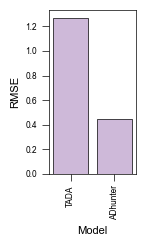

In [6]:
tmp_df = pd.DataFrame([[1.27,'TADA'],[0.449,'ADhunter']])
tmp_df.columns = ['RMSE','Model']
fig = plt.figure(figsize=(1.5,2.5))
g = sns.barplot(data=tmp_df,x='Model',y='RMSE',edgecolor='black',linewidth=0.5,color='#ceb9d9',alpha=1,saturation=1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-spectral_rmse.svg',bbox_inches='tight',transparent=False)

In [ ]:
cluster_df = pd.read_pickle(f'{GENERALIZABILITY_DIR}/01-dataset/cluster_df.pkl')
cluster_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['linear_harmonized_activity'].to_numpy().reshape(-1,1))
y = cluster_df['activity_scaled'].to_numpy()
threshold = cluster_df['activity_scaled'].median()
cluster_df['activity_bin'] = cluster_df['activity_scaled'].apply(lambda x: x >= 1.0)
cluster_df.to_pickle(f'{GENERALIZABILITY_DIR}/spectral_cluster_dataset.pkl')

if RUN_DIAMOND:
    df_to_fasta(cluster_df.query('cluster == 2'),'ID','AAseq',f'{GENERALIZABILITY_DIR}/test_cluster_seqs.faa')
    os.system(f'diamond blastp -d {DATASET_DIR}/03-waldburger/mycocosm_db.dmnd \
    -q {GENERALIZABILITY_DIR}/test_cluster_seqs.faa -o {GENERALIZABILITY_DIR}/test_cluster_matches.tsv --id 100')

cols = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen','qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
matches_df = pd.read_csv(f'{GENERALIZABILITY_DIR}/test_cluster_matches.tsv',sep='\t',names=cols)
matches_df = matches_df.query('length == 53').reset_index(drop=True)
matches_df['organism_id'] = matches_df['sseqid'].apply(lambda x: x.split('-')[0])
matches_df = matches_df.merge(cluster_df,left_on='qseqid',right_on='ID') #4109 -> 4109
matches_df = matches_df.drop(columns=['qseqid','qend','send','sseqid','pident','length','mismatch','gapopen','qstart','sstart','evalue','bitscore','linear_harmonized_activity','AAseq'])
matches_df['dataset'] = matches_df['dataset'].replace({'Hummel_Overlap':'Hummel'})
matches_df.to_pickle(f'{GENERALIZABILITY_DIR}/matches.pkl')

count_df = (matches_df
            .groupby(['organism_id'])['ID']
            .count()
            .reset_index()
            .rename(columns={'ID':'count'}))
count_df.to_csv(f'{GENERALIZABILITY_DIR}/test_counts.csv',index=False)